In [6]:
# MANUAL tSNE on MNIST dataset: 
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

In [11]:
mnist = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

In [8]:
from scipy.spatial.distance import cdist

In [12]:
print(x)
print(idx)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[ 2732 43567 42613 ... 12299 20379 49686]


(5000, 784)
(5000, 50)
(5000, 5000)
ConstKL:  -14.939576678850683


  0%|          | 0/200 [00:00<?, ?it/s]C:\Users\koola\AppData\Local\Temp\ipykernel_89124\4005721622.py:98: RuntimeWarning: divide by zero encountered in divide
  dist = 1.0 / (sum_Y2 - 2 * np.dot(Y, Y.T) + sum_Y2.T)


Iteration 0 KL divergence is 4.544883252828848


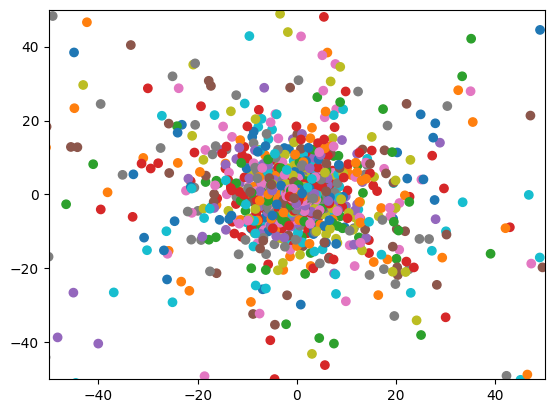

  5%|▌         | 10/200 [00:09<02:51,  1.11it/s]

Iteration 10 KL divergence is 5.97245086083147


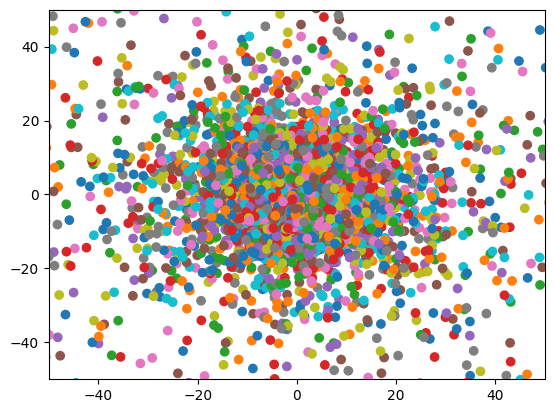

 10%|█         | 20/200 [00:18<02:41,  1.12it/s]

Iteration 20 KL divergence is 5.848440931914135


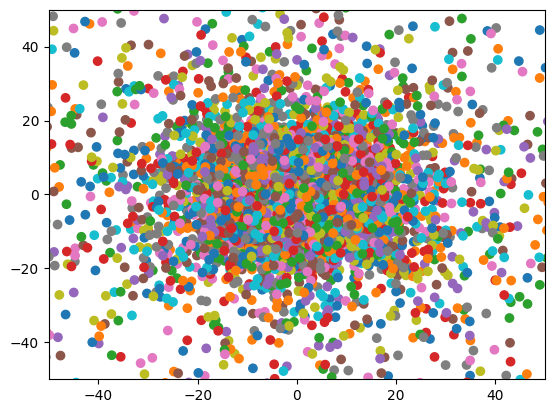

 15%|█▌        | 30/200 [00:28<02:34,  1.10it/s]

Iteration 30 KL divergence is 5.632657872236171


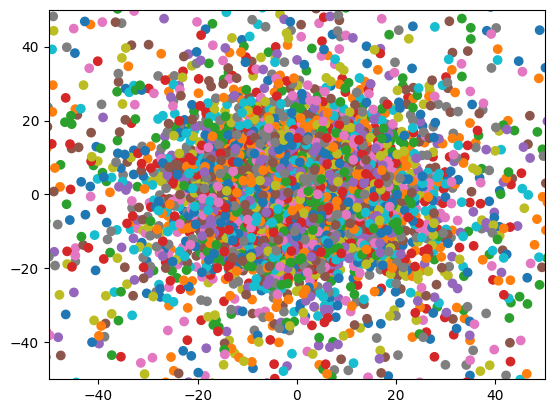

 20%|██        | 40/200 [00:37<02:24,  1.11it/s]

Iteration 40 KL divergence is 5.380777762129236


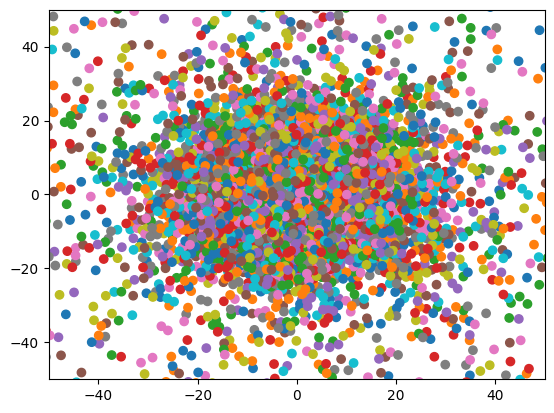

 25%|██▌       | 50/200 [00:47<02:22,  1.06it/s]

Iteration 50 KL divergence is 5.342929528353375


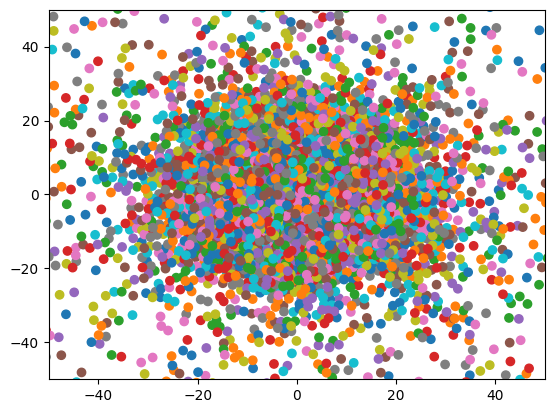

 30%|███       | 60/200 [00:57<02:10,  1.07it/s]

Iteration 60 KL divergence is 5.311607293258495


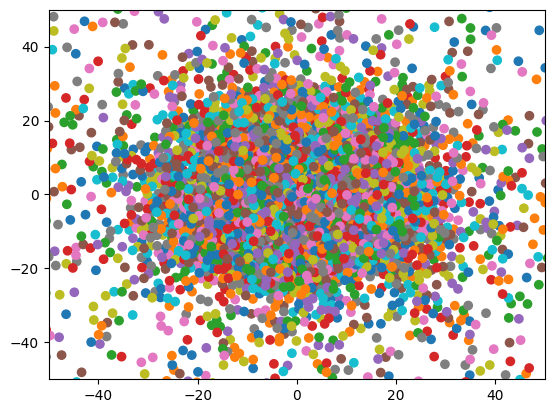

 35%|███▌      | 70/200 [01:06<01:56,  1.11it/s]

Iteration 70 KL divergence is 5.269521290232335


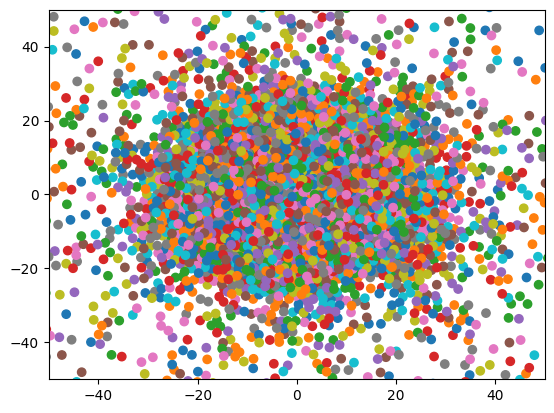

 37%|███▋      | 74/200 [01:11<02:02,  1.03it/s]


KeyboardInterrupt: 

In [38]:
# pseudocode: 

# load mnist into matrix X
x = mnist.data.numpy().reshape(-1, 28*28)
x = x.astype(np.float64)
y = mnist.targets.numpy()

# sample n images 
n = 5000
np.random.seed(0)
idx = np.random.choice(len(x), n)
x = x[idx]
print(x.shape)

# print(x)
# prep X: 0-1 range;
# x = x / 255
# x = x - x.mean(axis=0)
# print(np.mean(x, axis=0))
# print(np.mean(x, axis=1))
xx = x - np.min(x)
xx = xx / np.max(xx) # min-max normalization
xx = xx - np.mean(xx,axis=0)
# print(xx)
# run PCA to 50 dimensions
x = xx
pca = PCA(n_components=50)
x_pca = pca.fit_transform(x)

print(x_pca.shape)
# compute pairwise distance matrix D

D = cdist(x_pca, x_pca)

# compute similarities p_ij for each row i:
P = np.zeros([n, n])
for i in range(n):
    beta = 0.6
    D_i = D[i, :]
    P_i = np.zeros(n)
    # binary like search for beta(i)
    trials = 0
    hdiff = 1
    betamin = -np.inf
    betamax = np.inf
    while(np.abs(hdiff) > 1e-5 and trials < 50):
        P_i = np.exp(-D_i * beta)
        P_i_sum = np.sum(P_i)
        # betac = (betamin + betamax) / 2
        # h = np.sum(np.exp(-D_i * P_i_sum))
        h = np.log(P_i_sum) + beta * (np.dot(D_i, P_i)/P_i_sum)
        hdiff = h - np.log2(30)
        if hdiff > 0:
            # betac = (betamin + betamax) / 2
            betamin = beta
            if(betamax == np.inf):
                beta = beta * 2
            else:
                beta = (beta + betamax) / 2
        else:
            # betac = (betamin + betamax) / 2
            betamax = beta
            if(betamin == -np.inf):
                beta = beta / 2
            else:
                beta = (beta + betamin) / 2
    trials += 1
    # beta = betac
    P[i, :] = P_i  

#make sure P is correct
for i in range(n):
    P[i,i] = 1e-5

P = (P + P.T) / 2 # Symmetric
P = P / P.sum() # Normalized
# print(P[1,0])

print(P.shape)
constKL = np.sum(P * np.log(P))
print("ConstKL: ", constKL)
# initialize tSNE
max_iter = 200
epsilon = 500
min_gain = 0.01
Y = np.random.randn(n, 2)
# dY = np.zeros((n, 2))
iY = np.zeros([n, 2])
gains = np.ones([n, 2])

# run tSNE
for i in tqdm(range(max_iter)):
    # compute Q
    Y2 = Y**2
    sum_Y2 = np.sum(Y2, axis=1, keepdims=True)
    Q = np.zeros([n, n])
    
    dist = 1.0 / (sum_Y2 - 2 * np.dot(Y, Y.T) + sum_Y2.T)
    # Q = 1 / (1 + dist)
    np.fill_diagonal(dist, 1e-5)
    Q = dist / np.sum(dist)
    # Q = np.maximum(Q, 1e-12)
    
    # compute dY
    PQ = (P - Q) * dist

    # for k in range(n):
    #     dY[k] = np.sum(np.tile(PQ[:, k] * Q[:, k], (2, 1)).T * (Y[k] - Y), axis=0)
    dY = 4 * np.dot(np.diag(np.sum(PQ, axis=1)) - PQ, Y)
    
    # perform the update
    # if i == 0:
    #     gains = np.sign(dY) != np.sign(iY)
    # else:
    #     gains[gains > 20] = 20
    #     gains[gains < 0.01] = 0.01

    # iY = epsilon * iY - 0.2 * gains * dY
    iY = -epsilon * dY
    Y = Y + iY
    # Y = Y - np.tile(np.mean(Y, axis=0), (n, 1))
    Y = Y - np.mean(Y, axis=0)
    
    # compute the KL divergence
    if i % 10 == 0:
        C = constKL - np.sum(P * np.log(Q))
        print("Iteration", i, "KL divergence is", C)
        plt.scatter(Y[:, 0], Y[:, 1], c=y[idx], cmap='tab10')
        plt.xlim(-50, 50)
        plt.ylim(-50, 50)
        plt.show()

    